# Spyglass: Quick Start Demo

Welcome to [Spyglass](https://lorenfranklab.github.io/spyglass/1.4/),
a framework for reproducible and shareable neuroscientific data analysis,
built with [DataJoint](https://github.com/datajoint/datajoint-python/) and
maintained by the [Frank Lab](https://franklab.ucsf.edu/) at UCSF.

This is a Jupyter Notebook. To run the selected _cell_ and advance in this document, use `SHIFT+ENTER`

:::: {dropdown} 🎬To learn more about Spyglass from Dr. Loren Frank click HERE to watch the video.
:::{iframe} https://player.vimeo.com/video/922578532?title=0&portrait=0
:width:100%
:::

::::

Here, we will demonstrate some featues of spyglass. For the purposes of this demo, an NWB file has been ingested into the position, LFP, and spike sorting pipelines. We will retrieve data from the these pipelines and visualize them together to understand the tuning properties of hippocampal neurons.

To learn how this data is loaded, please review the other notebooks in this series.


## Quick Start Setup


This `00_HubQuickStart.ipynb` notebook is designed to be run on the JupyterHub set up at spyglass.hhmi.2i2c.cloud. If you are exploring Spyglass from your own machine, start with the notebook `00_Setup.ipynb` instead.


We will start by pre-loading some data into a the MySQL database used by Spyglass.


In [2]:
%%bash
mysql -h 127.0.0.1 -u root --password=tutorial < /home/jovyan/spyglass-demo/data/prepopulate.sql

::: {warning} Note
This step should take less than 20 seconds and the warning `mysql: [Warning] Using a password on the command line interface can be insecure.` is expected for this quick start demo.
:::

## Connection


First, we will set up connection to the database. This includes defining information such as the address of the server, the username, and the password. These are contained in `dj_local_conf.json` file.


In [3]:
import datajoint as dj
from pathlib import Path
import os

# change to the root directory of the project
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

dj.config.load(
    Path("dj_local_conf.json").absolute()
)  # load config for database connection info

## Data


We will examine the data in `mediumnwb20230802.nwb` from Loren Frank's lab at UCSF. This NWB file contains electrophysiological recordings of the rat hippocampus and PFC as the animal navigates a stem-leaf maze (it will be clear what this is later on). We will look at how the spiking of a hippocampal unit is modulated by factors such as the animal's position in the environment and the phase of the theta LFP.


In [4]:
import spyglass.common as sgc

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

nwb_file_name = "mediumnwb20230802.nwb"
nwb_copy_file_name = get_nwb_copy_filename(
    nwb_file_name
)  # this contains only the metadata and serves as a proxy for the nwb file

interval_list_name = (
    "pos 0 valid times"  # this is the name of the interval we will examine
)
electrode_group_name = 7  # we will look at data from tetrode 7
electrode_ids = (
    (sgc.Electrode & {"electrode_group_name": electrode_group_name})
    .fetch("electrode_id")
    .tolist()
)

[2024-03-13 12:23:14,303][INFO]: Connecting root@localhost:3309
[2024-03-13 12:23:14,311][INFO]: Connected root@localhost:3309


## Position Data


First, we will study the relationship between a hippocampal unit and place. The NWB file contains the (x,y) position of two LEDs on the animal's head, which has been extracted from the video recording of the animal during behavior with simple image processing. These often need to be processed further to reject incorrect positions and to smooth the data. To make this step reproducible, we have built a position processing pipeline, and the data has already been put through this pipeline. Let's examine the output stored in the `PositionOutput` table.


In [5]:
from spyglass.position import PositionOutput

PositionOutput()

merge_id,source
550a915c-00bd-5631-4fa4-c044c021dde9,TrodesPosV1


`PositionOutput` is a ["merge"](./03_Merge_Tables.ipynb) table, and contains as its only primary key (i.e. the set of columns that together uniquely define a row) a UUID (`merge_id`). Right now there is only one row in `PositionOutput`. The secondary key tells us that this comes from the `TrodesPosV1` pipeline upstream. We can get more information about this by looking at the associated parts table.


In [6]:
PositionOutput.TrodesPosV1()

merge_id,nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,trodes_pos_params_name name for this set of parameters
550a915c-00bd-5631-4fa4-c044c021dde9,mediumnwb20230802_.nwb,pos 0 valid times,default


This shows that this entry comes from our NWB file and the interval we selected. If we wanted, we could also examine the parameters used in the pipeline to process the data.


In [7]:
import spyglass.position.v1 as sp

merge_id = PositionOutput.fetch1("merge_id")
trodes_pos_params_name = (
    PositionOutput.TrodesPosV1 & {"merge_id": merge_id}
).fetch1("trodes_pos_params_name")
params = (
    sp.TrodesPosParams & {"trodes_pos_params_name": trodes_pos_params_name}
).fetch1("params")
params

{'max_LED_separation': 9.0,
 'max_plausible_speed': 300.0,
 'position_smoothing_duration': 0.125,
 'speed_smoothing_std_dev': 0.1,
 'orient_smoothing_std_dev': 0.001,
 'led1_is_front': 1,
 'is_upsampled': 0,
 'upsampling_sampling_rate': None,
 'upsampling_interpolation_method': 'linear'}

Roughly, we defined the row we wanted to look at by fetching the `merge_id`, identified the name of the parameter set used for processing the row, and fetched the paramters by querying the table that contains them. What the parameters represent is specific to the pipeline; what is important is that we can easily pull any information about the processed data.


Now let's load the processed position data. Although it is saved in the NWB format, we can get it as a `pandas` dataframe using the `fetch1_dataframe` method.


In [8]:
import numpy as np

position_info = PositionOutput().fetch1_dataframe()
position_info

,video_frame_ind,position_x,position_y,orientation,velocity_x,velocity_y,speed
time,,,,,,,
1.625936e+09,0,NaN,NaN,NaN,NaN,NaN,NaN
1.625936e+09,1,NaN,NaN,NaN,NaN,NaN,NaN
1.625936e+09,2,NaN,NaN,NaN,NaN,NaN,NaN
1.625936e+09,3,NaN,NaN,NaN,NaN,NaN,NaN
1.625936e+09,4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1.625937e+09,44186,38.483603,113.574868,-1.402199,1.008364,-0.865117,1.328618
1.625937e+09,44187,38.483603,113.521270,-1.398606,0.603148,-0.534938,0.806192
1.625937e+09,44188,38.430005,113.574868,-1.416478,0.256839,-0.219871,0.338096


As you can see, the results contain the timestamp for each frame (measured in Unix time), the x- and y-position, the orientation (in radians), the x- and y-components of the velocity, and the speed. Let's plot the position to get a sense of what the animal's behavior was like.


Text(0.5, 1.0, 'Position')

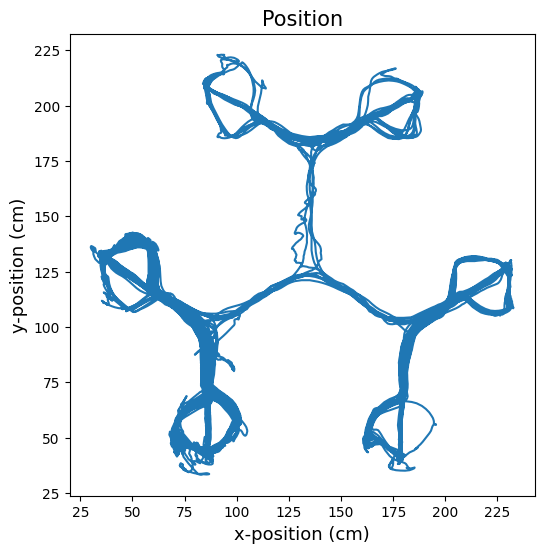

In [9]:
# we will ignore the first minute of data (1800 frames with 30 Hz frame rate),
# as it includes the time when the animal is being placed in the chamber
offset_ind = 1800
pos_x = position_info.position_x.to_numpy()[offset_ind:]
pos_y = position_info.position_y.to_numpy()[offset_ind:]
t_pos = np.asarray(position_info.index.tolist())[offset_ind:]


import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(pos_x, pos_y)
ax.set_xlabel("x-position (cm)", fontsize=13)
ax.set_ylabel("y-position (cm)", fontsize=13)
ax.set_title("Position", fontsize=15)

The plot shows a stem-leaf maze, which is so-named because it consists of three "stems" that originate from the center, each with two "leaves". At the end of each of the six leaves, there is a reward well that gives drops of milk probabilistically (you may know such a setup as a "multi-armed bandit" task). The "loops" by the reward wells indicate the times in which the animal turns around from the well (either to the left or to the right) to head to the next reward.


## Spike Sorting Data


Next, we will fetch a spike sorting from `SpikeSortingOutput` table. We will go through similar steps as we did for `PositionOutput` table. Again the results of spike sorting are saved as an NWB file, but this time we will load them using the `fetch_nwb` method. This returns a pointer to the relevant objects in the NWB file that you can then manipulate.


In [10]:
from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput

merge_id = (SpikeSortingOutput.CurationV1 & {"curation_id": 1}).fetch1(
    "merge_id"
)
nwb_pointer = (SpikeSortingOutput & {"merge_id": merge_id}).fetch_nwb()
nwb_pointer

/home/cb/miniconda3/envs/spy/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


[{'sorting_id': UUID('5d7564f8-1dc4-4c00-ba30-9324d79fd5a6'),
  'curation_id': 1,
  'analysis_file_name': 'mediumnwb20230802_ALNN6TZ4L7.nwb',
  'parent_curation_id': 0,
  'object_id':                                           spike_times   curation_label   
  id                                                                       
  1   [1625935703.3954985, 1625935703.419465, 162593...  [noise, reject]  \
  2   [1625935703.407565, 1625935703.4870985, 162593...  [noise, reject]   
  3   [1625935703.379465, 1625935703.444332, 1625935...  [noise, reject]   
  4   [1625935703.3900986, 1625935703.4081318, 16259...  [noise, reject]   
  5   [1625935703.3915653, 1625935703.426632, 162593...  [noise, reject]   
  6   [1625935737.3437426, 1625935759.9217722, 16259...               []   
  7   [1625935704.9557626, 1625935704.977396, 162593...               []   
  
     merge_groups        snr  isi_violation  nn_isolation  nn_noise_overlap   
  id                                                

What we are interested in is the `object_id` field, which links to the `units` table in the NWB file (a formal structure in the NWB format used to store spike times and other information about the units). Let's look at it.


In [11]:
units_df = nwb_pointer[0]["object_id"]
units_df

,spike_times,curation_label,merge_groups,snr,isi_violation,nn_isolation,nn_noise_overlap,peak_channel,num_spikes
id,,,,,,,,,
1,"[1625935703.3954985, 1625935703.419465, 162593...","[noise, reject]",[],4.194335,0.028175,0.749900,0.337500,28,29708
2,"[1625935703.407565, 1625935703.4870985, 162593...","[noise, reject]",[],5.038191,0.004448,0.866200,0.119300,28,25853
3,"[1625935703.379465, 1625935703.444332, 1625935...","[noise, reject]",[],3.972507,0.068645,0.814000,0.354600,29,57165
4,"[1625935703.3900986, 1625935703.4081318, 16259...","[noise, reject]",[],3.914364,0.039037,0.780100,0.371100,30,46854
5,"[1625935703.3915653, 1625935703.426632, 162593...","[noise, reject]",[],4.035854,0.029731,0.765200,0.383100,31,28658
6,"[1625935737.3437426, 1625935759.9217722, 16259...",[],[],9.493100,0.000000,0.972348,0.003160,31,886
7,"[1625935704.9557626, 1625935704.977396, 162593...",[],[],16.065277,0.000000,0.987664,0.002123,31,989


As you can see, there are 9 units (rows) in this spike sorting. For each unit, we can get the spike times (again in Unix times and already aligned with other data like position), curation labels, units to be merged with, and quality metrics. In this demo, we will examine unit 7, which is a well-sorted unit based on the `nn_isolation` (>0.95) and `nn_noise_overlap` (< 0.05) quality metrics. We will then we put a blue dot on the animal's position whenver this cell fires a spike. This reveals the "place field" of this cell.


Text(0.5, 1.0, 'Place field')

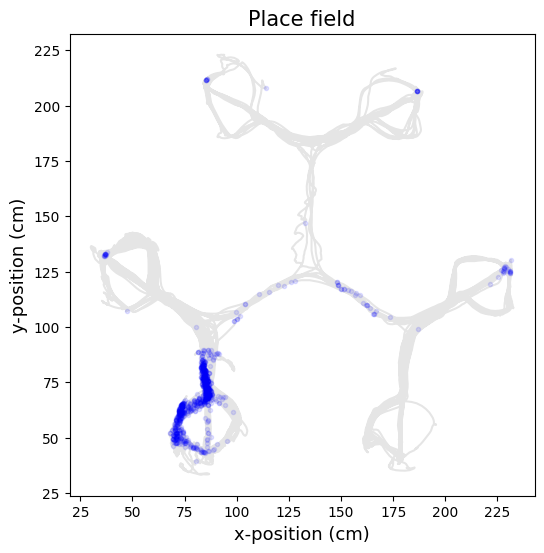

In [12]:
spike_times = units_df.iloc[6].spike_times
spike_pos = np.searchsorted(t_pos, spike_times)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(pos_x, pos_y, "k", alpha=0.1)
ax.plot(pos_x[spike_pos], pos_y[spike_pos], "b.", alpha=0.11)

ax.plot()
ax.set_xlabel("x-position (cm)", fontsize=13)
ax.set_ylabel("y-position (cm)", fontsize=13)
ax.set_title("Place field", fontsize=15)

As you can see, most of the cell's firing takes place near the bottom left reward well. Not only that, the firing seems specific to the trajectory in which the animal turns right from the bottom left reward well and moves out toward the stem. Clearly this unit's firing is highly correlated with the animal's position.


## LFP Data


In addition to place, hippocampal neurons are influenced by the theta (8-10 Hz) LFP. To examine this relationship, we will pull the LFP data filtered to isolate the theta band from `LFPBandV1` table. We will then plot it with the spiking from unit 7 whose place field we have plotted above. We will specifically look at a time when the animal is approaching the cell's place field center.


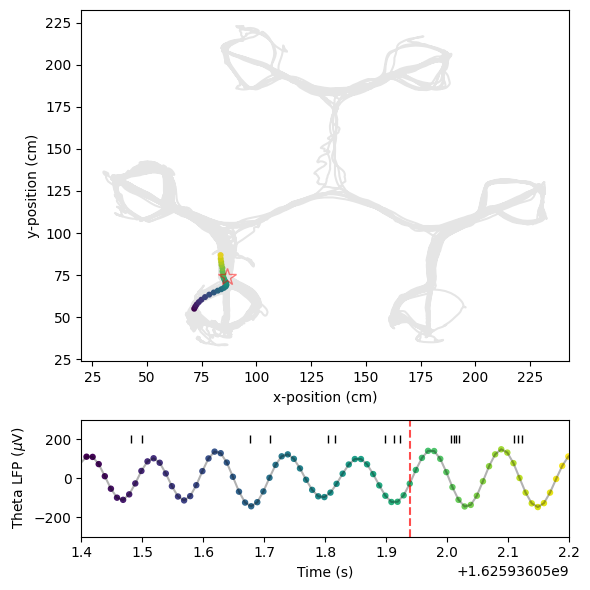

In [13]:
from spyglass.lfp.analysis.v1 import lfp_band

theta = lfp_band.LFPBandV1().fetch1_dataframe()
t_theta = np.asarray(theta.index.tolist())
theta_0 = theta[0].to_numpy()

import matplotlib.gridspec as gridspec

start_time = 6051.4 + 1.62593e9
stop_time = 6052.2 + 1.62593e9

t_pos_segment = t_pos[(t_pos > start_time) & (t_pos <= stop_time)]
t_pos_segment_normalized = (t_pos_segment - min(t_pos_segment)) / (
    max(t_pos_segment) - min(t_pos_segment)
)

t_theta_segment = t_theta[(t_theta > start_time) & (t_theta <= stop_time)]
t_theta_segment_normalized = (t_theta_segment - min(t_theta_segment)) / (
    max(t_theta_segment) - min(t_theta_segment)
)

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0])
ax1.plot(pos_x, pos_y, "k", alpha=0.1)

ax1.scatter(
    pos_x[(t_pos > start_time) & (t_pos <= stop_time)],
    pos_y[(t_pos > start_time) & (t_pos <= stop_time)],
    c=t_pos_segment_normalized,
    s=11,
    cmap="viridis",
)
ax1.plot(
    pos_x[spike_pos].mean(),
    pos_y[spike_pos].mean(),
    "r*",
    markersize=13,
    alpha=0.5,
    markerfacecolor="none",
)
ax1.set_xlabel("x-position (cm)")
ax1.set_ylabel("y-position (cm)")

distance_to_center = np.sqrt(
    (
        pos_x[(t_pos > start_time) & (t_pos <= stop_time)]
        - np.mean(pos_x[spike_pos])
    )
    ** 2
    + (
        pos_y[(t_pos > start_time) & (t_pos <= stop_time)]
        - np.mean(pos_y[spike_pos])
    )
    ** 2
)
i = np.searchsorted(
    t_theta_segment, t_pos_segment[np.argmin(distance_to_center)]
)

ax2 = fig.add_subplot(gs[1])
ax2.plot(t_theta, theta_0, "k", alpha=0.3)
ax2.scatter(
    t_theta_segment,
    theta_0[(t_theta > start_time) & (t_theta <= stop_time)],
    c=t_theta_segment_normalized,
    s=13,
    cmap="viridis",
)
ax2.axvline(t_theta_segment[i], color="r", linestyle="--", alpha=0.7)

ax2.plot(spike_times, 200 * np.ones(len(spike_times)), "k|")
ax2.set_xlim([start_time, stop_time])
ax2.set_ylim([-300, 300])
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Theta LFP ($\mu$V)")

plt.tight_layout()

In the plot above, time is represented as a colormap from dark blue (early) to yellow (late). The red star in the upper panel and the red vertical dashed line in lower panel represent the center of the cell's place field, estimated by computing the centroid of the spiking locations. As you can see, as the animal gets closer to the place field center, the theta phase at which the cell fires changes from late to early (assuming that 0 phase is the peak of the oscillation). You also see that more spikes appear later, as expected from the place tuning.


Let's examine this more closely. One feature of `datajoint` pipelines used in Spyglass is that the structure that saves the data (tables) and the code for manipulating the data and populating the tables are tightly associated (specifically, as a _class_ and _method_ in object-oriented programming lingo). Here we will use the `compute_signal_phase` method of `LFPBandV1` table to estimate the phase of each time point in the theta LFP, and use this to identify the theta phase of each spike. We will then plot a histogram of the theta phase at which spiking occurred in polar coordinates.


Text(0.5, 0, 'Theta phase (rad)')

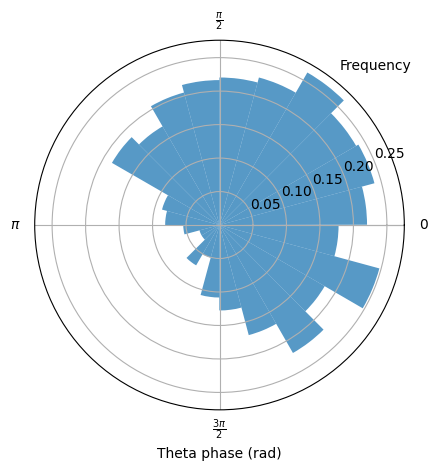

In [14]:
theta_phase = lfp_band.LFPBandV1().compute_signal_phase(
    electrode_list=electrode_ids
)
# we will just use one electrode for this example
theta_phase_elec28 = theta_phase["electrode 28"].to_numpy()
t_theta_phase = np.asarray(theta_phase.index.tolist())

spike_theta_phase = np.searchsorted(t_theta_phase, spike_times)

fig, ax = plt.subplots(subplot_kw={"polar": True})

n, bins, patches = ax.hist(
    theta_phase_elec28[spike_theta_phase],
    bins=24,
    density=True,
    histtype="bar",
    alpha=0.75,
)

r_label_position = max(n) * 1.25
ax.text(
    np.radians(45),
    r_label_position,
    "Frequency",
    horizontalalignment="center",
    color="black",
)

ax.set_xticks(np.linspace(0, 2 * np.pi, 5))
ax.set_xticklabels(["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", ""])
ax.set_xlabel("Theta phase (rad)")

Most of the spikes are in the first two quadrants, indicating that they fire early in the theta phase. But there is a significant number of spikes that fire late in theta. We will next show that these fire when animal is relatively far away from the cell's place field.


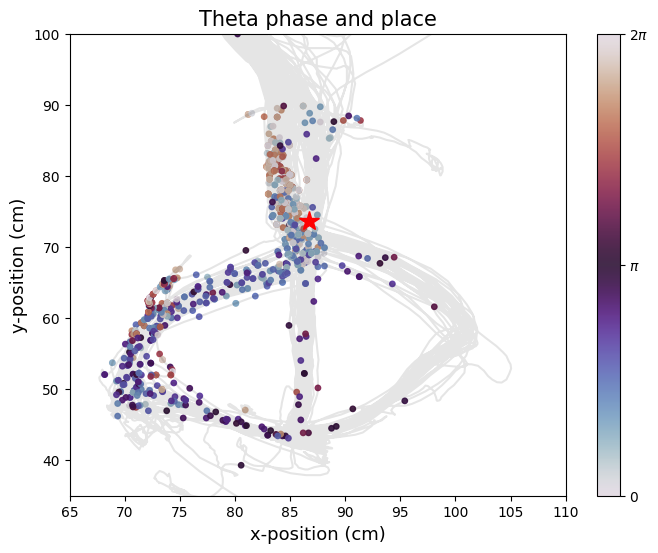

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(pos_x, pos_y, "k", alpha=0.1)
scatter = ax.scatter(
    pos_x[spike_pos],
    pos_y[spike_pos],
    c=theta_phase_elec28[spike_theta_phase],
    cmap="twilight",
    vmin=0,
    vmax=2 * np.pi,
    alpha=0.9,
    s=15,
)
ax.plot(pos_x[spike_pos].mean(), pos_y[spike_pos].mean(), "r*", markersize=15)
ax.set_xlabel("x-position (cm)", fontsize=13)
ax.set_ylabel("y-position (cm)", fontsize=13)
ax.set_title("Theta phase and place", fontsize=15)
ax.set_xlim([65, 110])
ax.set_ylim([35, 100])
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_ticks([0, np.pi, 2 * np.pi])
cbar.set_ticklabels(["0", "$\pi$", "$2 \pi$"])

In the plot above, the dots and the colors represent the position and the theta phase at which each spike was fired. As you can see, the spikes whose phase tuning is close to 0 (red and blue) tend to be found near the place field center (red star), whereas the spikes whose phase tuning is farther away from 0 (purple) appear _before_ the animal enters the place field center--sometimes more than 20 cm earlier. This suggests an intriguing hypothesis: could these serve as predictions or simulations of the near future?
